In [4]:
from evo.core import metrics
from evo.core.units import Unit

### set up 

In [10]:
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint
import numpy as np

from evo.tools.settings import SETTINGS
SETTINGS.plot_backend = 'inline'
from evo.tools import plot
import matplotlib.pyplot as plt

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

plot.apply_settings(SETTINGS)
# %matplotlib inline
# %matplotlib notebook  # For vscode: % matplotlib widget

[DEBUG][2025-01-29 15:04:29,632][log.configure_logging():113]
System info:
Python 3.9.20
Linux-6.8.0-51-generic-x86_64-with-glibc2.39
sergio@Asimov



### read trajectories 

In [11]:
from evo.tools import file_interface

ref_file = "/media/jbhayet/Data/datasets/SLAM/tum/rgbd_dataset_freiburg1_desk/groundtruth.txt"
est_file = "/media/jbhayet/Data/datasets/SLAM/tum/rgbd_dataset_freiburg1_desk/groundtruth.txt"

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est = file_interface.read_tum_trajectory_file(est_file)

[DEBUG][2025-01-29 15:04:34,764][file_interface.read_tum_trajectory_file():118]
Loaded 2335 stamps and poses from: /media/jbhayet/Data/datasets/SLAM/tum/rgbd_dataset_freiburg1_desk/groundtruth.txt
[DEBUG][2025-01-29 15:04:34,777][file_interface.read_tum_trajectory_file():118]
Loaded 2335 stamps and poses from: /media/jbhayet/Data/datasets/SLAM/tum/rgbd_dataset_freiburg1_desk/groundtruth.txt


### synchonize trajectories 

In [4]:
from evo.core import sync

max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)

[DEBUG][2025-01-29 12:08:15,523][sync.associate_trajectories():110]
Found 2335 of max. 2335 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


In [5]:
import copy

traj_est_aligned = copy.deepcopy(traj_est)
traj_est_aligned.align(traj_ref, correct_scale=False, correct_only_scale=False)

[DEBUG][2025-01-29 12:08:18,363][trajectory.align():247]
Aligning using Umeyama's method...
[DEBUG][2025-01-29 12:08:18,403][trajectory.align():259]
Rotation of alignment:
[[ 1.00000000e+00 -7.02820390e-17 -4.28131732e-18]
 [ 1.09583457e-17  1.00000000e+00 -4.10809203e-17]
 [-4.28131732e-18 -6.86754520e-17  1.00000000e+00]]
Translation of alignment:
[ 0.00000000e+00  5.55111512e-17 -2.22044605e-16]
[DEBUG][2025-01-29 12:08:18,405][trajectory.align():261]
Scale correction: 1.0


(array([[ 1.00000000e+00, -7.02820390e-17, -4.28131732e-18],
        [ 1.09583457e-17,  1.00000000e+00, -4.10809203e-17],
        [-4.28131732e-18, -6.86754520e-17,  1.00000000e+00]]),
 array([ 0.00000000e+00,  5.55111512e-17, -2.22044605e-16]),
 1.0)

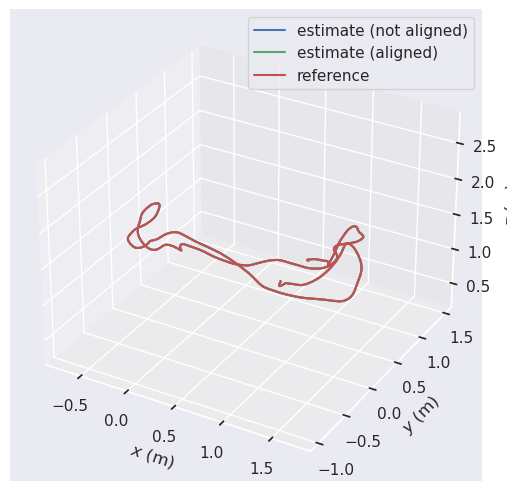

In [6]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

### APE
(absolute pose error)

$$
E_{i,j} = P_{\text{est},i} \ominus P_{\text{ref},i} = P_{\text{est},i}^{-1} P_{\text{ref},j} \in \text{SE}(3)
$$

for each timestamp $i$

In [7]:
# set which part of the trajectory are you interested in evaluate 
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = True 

if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)

In [8]:
# instantiate a metric and process data 
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

[DEBUG][2025-01-29 12:09:48,945][metrics.process_data():412]
Compared 2335 absolute pose pairs.
[DEBUG][2025-01-29 12:09:48,947][metrics.process_data():413]
Calculating APE for translation part pose relation...


In [9]:
# get a single statistic 
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

1.292725747241699e-16


In [10]:
# get all statistics 
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

{'max': 2.254873622441467e-16,
 'mean': 8.157973472647999e-17,
 'median': 1.3877787807814457e-17,
 'min': 0.0,
 'rmse': 1.292725747241699e-16,
 'sse': 3.9021115674530586e-29,
 'std': 1.0028033435212136e-16}


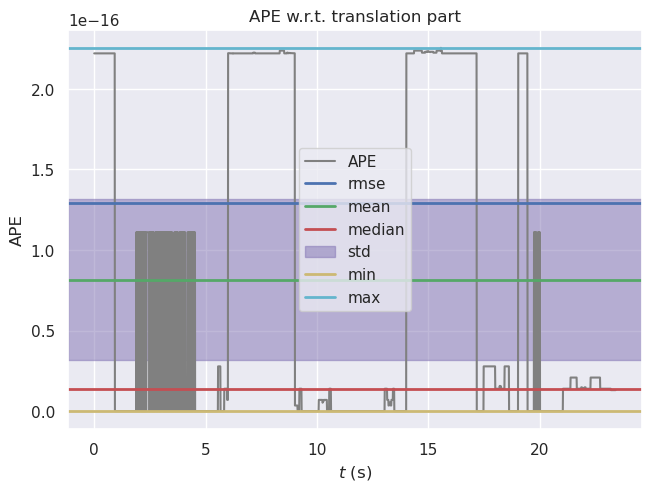

In [11]:
# plot the APE values and statistics
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

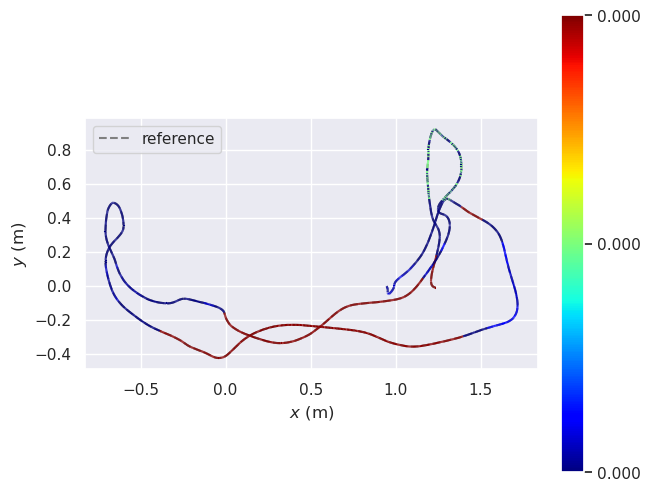

In [12]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [13]:
# ---> now for the rotation component of the trajectory
# set pose relation 
pose_relation = metrics.PoseRelation.rotation_angle_rad
# set data 
data = (traj_ref, traj_est_aligned) 
# instantiate data 
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)
# get rmse 
# get a single statistic 
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

[DEBUG][2025-01-29 12:21:34,482][metrics.process_data():412]
Compared 2335 absolute pose pairs.
[DEBUG][2025-01-29 12:21:34,484][metrics.process_data():413]
Calculating APE for rotation angle in radians pose relation...
4.8244132438056975e-17


### RPE
(relative pose error)

$$
E_{i,j} = \delta_{\text{est},i,j} \ominus \delta_{\text{ref},i,j} = (P_{\text{ref},i}^{-1} P_{\text{ref},j})^{-1} (P_{\text{est},i}^{-1} P_{\text{est},j}) \in \text{SE}(3)
$$

for each timestamp $i, j$

[DEBUG][2025-01-29 12:44:50,666][metrics.id_pairs_from_delta():469]
Found 2334 pairs with delta 1 (frames) among 2335 poses using consecutive pairs.


[DEBUG][2025-01-29 12:44:50,721][metrics.process_data():313]
Compared 2334 relative pose pairs, delta = 1 (frames) with consecutive pairs.
[DEBUG][2025-01-29 12:44:50,722][metrics.process_data():319]
Calculating RPE for rotation angle in degrees pose relation...
0.0
{'max': 0.0,
 'mean': 0.0,
 'median': 0.0,
 'min': 0.0,
 'rmse': 0.0,
 'sse': 0.0,
 'std': 0.0}


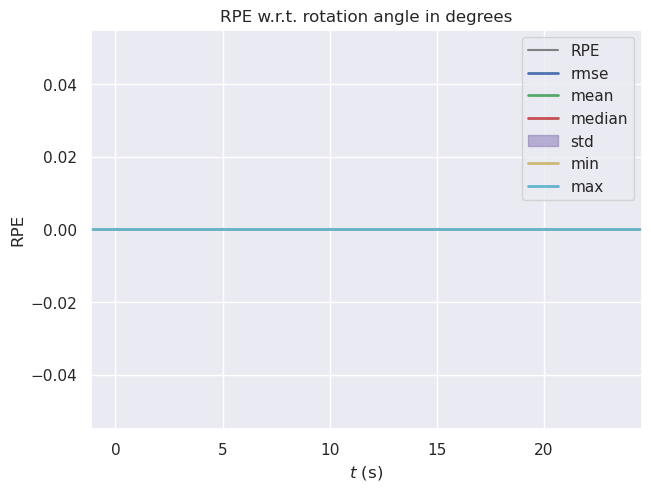

In [16]:
pose_relation = metrics.PoseRelation.rotation_angle_deg

# normal mode
delta = 1
delta_unit = Unit.frames

# all pairs mode
all_pairs = False  # activate

# set data 
data = (traj_ref, traj_est)

# instantiate and RPE class
rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
rpe_metric.process_data(data)

# get rmse 
rpe_stat = rpe_metric.get_statistic(metrics.StatisticsType.rmse)
print(rpe_stat)

# get all statistics 
rpe_stats = rpe_metric.get_all_statistics()
pprint.pprint(rpe_stats)

# plot statistics 
# important: restrict data to delta ids for plot
import copy
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

fig = plt.figure()
plot.error_array(fig.gca(), rpe_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in rpe_stats.items() if s != "sse"},
                 name="RPE", title="RPE w.r.t. " + rpe_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

### customize functions to evaluate metrics 

In [15]:
import os 
import json 
from gaussian_splatting.utils.system_utils import mkdir_p
from utils.logging_utils import Log

def compute_metric(data: tuple, metric: str, pose_relation: metrics.PoseRelation):
    if metric == 'APE':
        pe_metric = metrics.APE(pose_relation)
    elif metric == 'RPE':
        # normal mode
        delta = 1
        delta_unit = Unit.frames
        all_pairs = False  # activate
        pe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
    else:
        assert False, "Metric not identified: {}".format(metric)

    pe_metric.process_data(data)
    pe_stat = pe_metric.get_statistic(metrics.StatisticsType.rmse)
    pe_stats = pe_metric.get_all_statistics()
    return pe_stat, pe_stats


def evaluate_evo(poses_gt, poses_est, plot_dir, label, monocular=False):
    # sincronize data & align 
    max_diff = 0.01
    traj_ref, traj_est = sync.associate_trajectories(poses_gt, poses_est, max_diff)
    traj_est_aligned = copy.deepcopy(traj_est)
    traj_est_aligned.align(traj_ref, correct_scale=False, correct_only_scale=False)

    ## RMSE
    metrics = ["APE", "RPE"]
    pose_relations = [metrics.PoseRelation.translation_part, metrics.PoseRelation.rotation_angle_rad]
    data = (traj_ref, traj_est_aligned)
    stats_full = {}
    pe_stat = {}
    for metric in metrics:
        curr_stats = {}
        for pose_relation in pose_relations:
            pe_stat, pe_stats = compute_metric(data, metric, pose_relation)
            curr_stats[str(pose_relation)] = pe_stats
            Log(f"RMSE {metric}/{str(pose_relation)} [m]", pe_stat, tag="Eval")
        stats_full[metric] = curr_stats

    with open(
        os.path.join(plot_dir, "stats_{}.json".format(str(label))),
        "w",
        encoding="utf-8",
    ) as f:
        json.dump(stats_full, f, indent=4)

    plot_mode = plot.PlotMode.xy
    fig = plt.figure()
    ax = plot.prepare_axis(fig, plot_mode)
    plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
    plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                    plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
    ax.legend()
    plt.show()
    plt.savefig(os.path.join(plot_dir, "evo_2dplot_{}.png".format(str(label))), dpi=90)

    return ape_stat

def eval_trajectory(frames, kf_ids, save_dir, iterations, final=False, monocular=False):
    trj_data = dict()
    latest_frame_idx = kf_ids[-1] + 2 if final else kf_ids[-1] + 1
    trj_id, trj_est, trj_gt = [], [], []
    trj_est_np, trj_gt_np = [], []

    def gen_pose_matrix(R, T):
        pose = np.eye(4)
        pose[0:3, 0:3] = R.cpu().numpy()
        pose[0:3, 3] = T.cpu().numpy()
        return pose

    for kf_id in kf_ids:
        kf = frames[kf_id]
        pose_est = np.linalg.inv(gen_pose_matrix(kf.R, kf.T))
        pose_gt = np.linalg.inv(gen_pose_matrix(kf.R_gt, kf.T_gt))

        trj_id.append(frames[kf_id].uid)
        trj_est.append(pose_est.tolist())
        trj_gt.append(pose_gt.tolist())

        trj_est_np.append(pose_est)
        trj_gt_np.append(pose_gt)

    trj_data["trj_id"] = trj_id
    trj_data["trj_est"] = trj_est
    trj_data["trj_gt"] = trj_gt

    plot_dir = os.path.join(save_dir, "plot")
    mkdir_p(plot_dir)

    label_evo = "final" if final else "{:04}".format(iterations)
    with open(
        os.path.join(plot_dir, f"trj_{label_evo}.json"), "w", encoding="utf-8"
    ) as f:
        json.dump(trj_data, f, indent=4)

    ate = evaluate_evo(
        poses_gt=trj_gt_np,
        poses_est=trj_est_np,
        plot_dir=plot_dir,
        label=label_evo,
        monocular=monocular,
    )
    # wandb.log({"frame_idx": latest_frame_idx, "ate": ate})
    return ate

ape_stat = eval_trajectory()

In [18]:
print(str(metrics.PoseRelation.translation_part))

PoseRelation.translation_part
